In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Dense, Activation, Dropout
from keras.utils.data_utils import get_file
from keras.layers import SimpleRNN, Lambda
from __future__ import print_function
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.models import Model
import numpy as np
import random
import sys

# Read input file

path = 'input.txt'
text = open(path).read()
print('Corpus length:', len(text))

# Number of characters in vocabulary

chars = set(text)
print('Number of unique characters:', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Create training set

maxlen = 25
step = 25
sentences = []
out_sent = []
next_chars = []

for i in range(0, len(text) - maxlen - 1, step):
    sentences.append(text[i: i + maxlen])
    out_sent.append(text[i + 1: i + maxlen + 1])
    next_chars.append(text[i + maxlen])
nEg = len(sentences)
print("")

# One-hot encoding of input

print('One-hot encoding of input...')

X = np.zeros((len(sentences), maxlen, len(chars)), dtype = np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
        
Y = np.zeros((len(out_sent), maxlen, len(chars)), dtype = np.bool)
for i, sentence in enumerate(out_sent):
    for t, char in enumerate(sentence):
        Y[i, t, char_indices[char]] = 1
        
print('Number of examples:', nEg)

Using TensorFlow backend.


Corpus length: 501470
Number of unique characters: 93

One-hot encoding of input...
Number of examples: 20058


In [2]:
print('Building model...')

# Network parameters

nHiddenUnits = 100
dropout = 0.0
T = 1
grad_optimizer = 'rmsprop'

# Model of our RNN

model = Sequential()
model.add(SimpleRNN(nHiddenUnits, input_shape = (maxlen, len(chars)), return_sequences = True, dropout_W = 0.0, dropout_U = dropout))
model.add(Dense(len(chars), activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=grad_optimizer, metrics=['accuracy'])

Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
simplernn_1 (SimpleRNN)          (None, 25, 100)       19400       simplernn_input_1[0][0]          
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 25, 93)        9393        simplernn_1[0][0]                
Total params: 28,793
Trainable params: 28,793
Non-trainable params: 0
____________________________________________________________________________________________________


In [3]:
print('Training...')
hist = model.fit(X, Y, batch_size = 32, nb_epoch = 30, verbose = 2, validation_split = 0.2, shuffle = True)
print(hist.history)

print('Training done!')

Training...
Train on 16046 samples, validate on 4012 samples
Epoch 1/30
24s - loss: 2.9560 - acc: 0.2647 - val_loss: 2.5595 - val_acc: 0.2932
Epoch 2/30
24s - loss: 2.2706 - acc: 0.3987 - val_loss: 2.3181 - val_acc: 0.3406
Epoch 3/30
23s - loss: 2.0870 - acc: 0.4317 - val_loss: 2.2123 - val_acc: 0.3617
Epoch 4/30
24s - loss: 1.9900 - acc: 0.4497 - val_loss: 2.1354 - val_acc: 0.3817
Epoch 5/30
26s - loss: 1.9267 - acc: 0.4619 - val_loss: 2.1015 - val_acc: 0.3847
Epoch 6/30
24s - loss: 1.8819 - acc: 0.4705 - val_loss: 2.0613 - val_acc: 0.3960
Epoch 7/30
23s - loss: 1.8480 - acc: 0.4772 - val_loss: 2.0421 - val_acc: 0.3979
Epoch 8/30
25s - loss: 1.8220 - acc: 0.4822 - val_loss: 2.0338 - val_acc: 0.4008
Epoch 9/30
25s - loss: 1.8005 - acc: 0.4867 - val_loss: 2.0416 - val_acc: 0.4011
Epoch 10/30
23s - loss: 1.7814 - acc: 0.4903 - val_loss: 2.0064 - val_acc: 0.4122
Epoch 11/30
25s - loss: 1.7653 - acc: 0.4937 - val_loss: 1.9997 - val_acc: 0.4104
Epoch 12/30
24s - loss: 1.7512 - acc: 0.4969 -

In [19]:
score = model.evaluate(X, Y, verbose = 0)
print("Final training statistics", score)

Final training statistics [1.7033148487634799, 0.50459866407136522]
Final cross-validation statistics [1.7023146308193415, 0.50591226556484148]


In [4]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [5]:
# finding position of seed "<start>"

count = 0
pos_start = []
start = 0
while count < 1000:
    index = text.find('<start>', start, len(text))
    pos_start.append(index)
    start = index + 1
    count += 1

In [7]:
# Open file to be write music in

f = open('musicgenout.txt','w')
temperature = 1

# Compose music
print('Composing music...')
for iteration in range(1):
    rand_index = np.random.randint(len(pos_start))
    start_index = pos_start[rand_index]

    print()
    generated = ''

    # "Prime" with random seed
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    f.write(generated)

    # Generate music using feedback in RNN
    for i in range(2000):
        x = np.zeros((1, maxlen, len(chars)))

        # Make input vector
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1
        
        # Generate next characters
        pred_chars = ''
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds[-1], temperature)
        next_char = indices_char[next_index]
        f.write(next_char)
        generated += next_char

        # Feedback to input
        sentence = sentence[1:] + next_char
    f.write('\n\n')
f.close()
print('Music generated!')

Composing music...

Music generated!


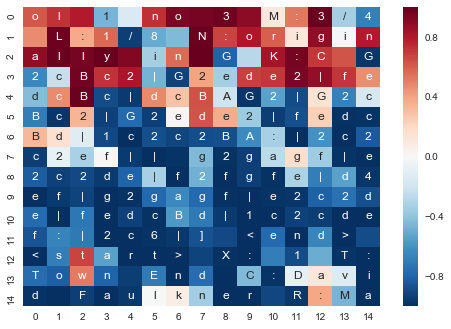

In [10]:
output_layer = model.layers[0].output
activationModel = Model(input = model.input, output = output_layer)

pred_arr = []
labels = []

start = random.randint(0,len(text)-maxlen-1)

steps = 9
x = np.zeros((1,maxlen,len(chars)))

pred_arr = []

labels = []

for i in range(steps):
    sen_i  = text[start:start+maxlen]
    start  += maxlen
    for t, char in enumerate(sen_i):
        x[0, t, char_indices[char]] = 1
        labels.append(char)
    pred_i = activationModel.predict(x,verbose=0)[0]
    pred_arr.append(pred_i)
    
pred_arr = np.array(pred_arr).reshape((15, 15, 100))
labels = np.array(labels).reshape((15, 15))

import seaborn as sns

sns.heatmap(pred_arr[:, :, -2], annot = labels, fmt = '')
sns.plt.show()
